# Understanding VLM-Lens Database Files: A Complete Guide

## What are VLM-Lens Database Files?

VLM-Lens stores extracted neural network activations (tensors/embeddings) in SQLite database files with the `.db` extension. These databases contain:

- **Model activations**: Raw tensor data from specific layers during inference
- **Metadata**: Information about the model, input images, prompts, and processing context
- **Timestamps**: When each activation was captured
- **Layer information**: Which specific layer or component the activation came from

## Database Structure

The primary table `tensors` stores all activation data with the following schema:
- `id` (INTEGER, PRIMARY KEY): Unique identifier for each activation
- `name` (TEXT): Model name/identifier
- `architecture` (TEXT): Model architecture type
- `timestamp` (DATETIME): When the activation was captured
- `image_path` (TEXT): Path to the input image
- `prompt` (TEXT): Text prompt used during inference
- `label` (TEXT): Optional label or classification
- `layer` (TEXT): Specific layer/component name
- `tensor` (BLOB): Serialized tensor data

## Step 0: Getting Started

Let's explore a sample VLM-Lens database to understand its contents and structure.
Run the following command to generate `output/llava.db`.
```
python src/main.py --config configs/models/llava-7b/llava-7b.yaml
```


In [14]:
!python src/main.py --config configs/models/llava-7b/llava-7b.yaml

Loading checkpoint shards: 100%|██████████████████| 3/3 [00:01<00:00,  1.52it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Step 1: Connecting to the Database and Examining Schema

First, we'll connect to the database and examine its structure using SQLite's built-in introspection capabilities.

In [1]:
import sqlite3

# Connect to your database
conn = sqlite3.connect("output/llava.db")
conn.row_factory = sqlite3.Row
cur = conn.cursor()

### Understanding the Schema with PRAGMA table_info

The `PRAGMA table_info()` command is a SQLite introspection feature that returns detailed information about a table's structure:

```python
for r in cur.execute("PRAGMA table_info(tensors)"):
    print(dict(r))
```

**What this does:**
- `PRAGMA table_info(tensors)` queries SQLite's system catalog for metadata about the `tensors` table
- Returns one row per column with detailed schema information
- `sqlite3.Row` objects are converted to dictionaries for readable output

**Each row contains:**
- `cid`: Column ID (position in table, starting from 0)
- `name`: Column name
- `type`: Data type (INTEGER, TEXT, BLOB, etc.)
- `notnull`: Whether column requires a value (1 = required, 0 = optional)
- `dflt_value`: Default value if any (or None)
- `pk`: Primary key flag (1 = primary key, 0 = not primary key)

This introspection is essential for understanding the database structure before querying or analyzing the stored tensor data.

In [2]:
for r in cur.execute("PRAGMA table_info(tensors)"):
    print(dict(r))

{'cid': 0, 'name': 'id', 'type': 'INTEGER', 'notnull': 0, 'dflt_value': None, 'pk': 1}
{'cid': 1, 'name': 'name', 'type': 'TEXT', 'notnull': 1, 'dflt_value': None, 'pk': 0}
{'cid': 2, 'name': 'architecture', 'type': 'TEXT', 'notnull': 1, 'dflt_value': None, 'pk': 0}
{'cid': 3, 'name': 'timestamp', 'type': 'DATETIME', 'notnull': 0, 'dflt_value': 'CURRENT_TIMESTAMP', 'pk': 0}
{'cid': 4, 'name': 'image_path', 'type': 'TEXT', 'notnull': 1, 'dflt_value': None, 'pk': 0}
{'cid': 5, 'name': 'prompt', 'type': 'TEXT', 'notnull': 1, 'dflt_value': None, 'pk': 0}
{'cid': 6, 'name': 'label', 'type': 'TEXT', 'notnull': 0, 'dflt_value': None, 'pk': 0}
{'cid': 7, 'name': 'layer', 'type': 'TEXT', 'notnull': 1, 'dflt_value': None, 'pk': 0}
{'cid': 8, 'name': 'tensor', 'type': 'BLOB', 'notnull': 1, 'dflt_value': None, 'pk': 0}


## Step 2: Exploring the Actual Data

Now that we understand the database schema, let's examine the actual tensor data stored in the database:

### SELECT Clause
The query selects specific columns from the `tensors` table:
- `id`: Primary key identifier for each stored activation
- `name`: Model identifier (e.g., "llava-hf/llava-1.5-7b-hf")
- `architecture`: Model architecture type (e.g., "llava")
- `timestamp`: When this activation was captured
- `image_path`: Full path to the input image used
- `prompt`: Text prompt given to the model
- `label`: Optional classification or label (often NULL)
- `layer`: Specific model component (e.g., "vision_tower.vision_model")
- `length(tensor) AS tensor_bytes`: **Size of the BLOB data in bytes**

### LIMIT Clause

`LIMIT 10` restricts results to the first 10 records, which is essential because:
- VLM databases can contain thousands of tensor activations
- Each tensor can be tens of megabytes (as we see: ~59MB each)
- We want a quick sample for exploration, not the entire dataset

In [8]:
for r in cur.execute("""
  SELECT id, name, architecture, timestamp, image_path, prompt, label, layer,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 10
"""):
    print(dict(r))

{'id': 1, 'name': 'llava-hf/llava-1.5-7b-hf', 'architecture': 'llava', 'timestamp': '2025-08-21 00:03:43', 'image_path': '/home/marstin/Documents/vlm-lens/data/test-images/black_in_blue.png', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'vision_tower.vision_model', 'tensor_bytes': 59096072}
{'id': 2, 'name': 'llava-hf/llava-1.5-7b-hf', 'architecture': 'llava', 'timestamp': '2025-08-21 00:03:53', 'image_path': '/home/marstin/Documents/vlm-lens/data/test-images/black_in_black.png', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'vision_tower.vision_model', 'tensor_bytes': 59096072}


### What the Output Tells Us

From the sample output, we can see:
- **Model**: All entries use "llava-hf/llava-1.5-7b-hf"
- **Layer**: All from "vision_tower.vision_model" (vision encoder)
- **Tensor size**: ~59MB each (59,096,072 bytes)
- **Images**: Different test images with color-related prompts
- **Prompts**: Consistent "Describe the color in this image in one word"

This query pattern is perfect for initial data exploration and understanding what's stored in your VLM-Lens database before proceeding with tensor analysis.

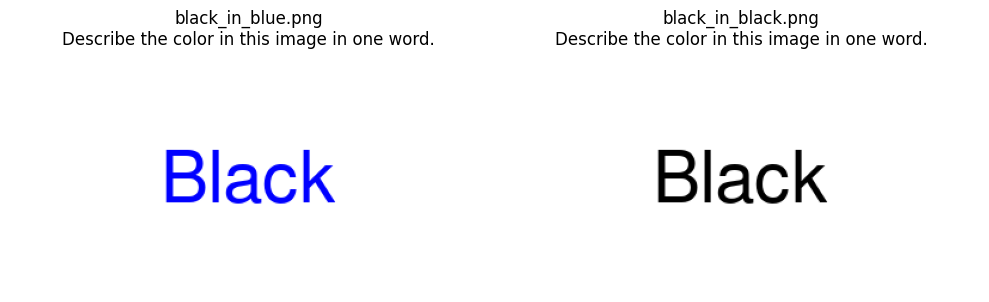

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import textwrap, pathlib

images = [
    ("./data/test-images/black_in_blue.png",
     "Describe the color in this image in one word."),
    ("./data/test-images/black_in_black.png",
     "Describe the color in this image in one word."),
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax, (path, prompt) in zip(axes, images):
    img = Image.open(path).convert("RGB")
    ax.imshow(img)
    title = f"{pathlib.Path(path).name}\n" + "\n".join(textwrap.wrap(prompt, width=60))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Step 3: Retrieving and Deserializing Tensor Data

### Core Functions for Working with VLM-Lens Tensors

```python
def retrieve_pk_embeddings(db_path="output/llava.db", limit=None):
def get_embedding_by_pk(db_path="output/llava.db", pk_id=None):
```

**Note**: You need `io.BytesIO(tensor_bytes)` when loading tensor bytes.

In [26]:
import numpy as np
import torch
import io


def cosine_similarity_numpy(a, b):
    """Calculate cosine similarity between two vectors using numpy with robust error handling."""
    # Check for NaN or infinite values
    if not (np.isfinite(a).all() and np.isfinite(b).all()):
        print("Warning: NaN or infinite values detected in tensors")
        return 0.0
    
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    # Handle zero vectors or invalid norms
    if norm_a == 0 or norm_b == 0 or not (np.isfinite(norm_a) and np.isfinite(norm_b)):
        return 0.0
    
    dot_product = np.dot(a, b)
    
    # Check if dot product is valid
    if not np.isfinite(dot_product):
        print("Warning: Invalid dot product")
        return 0.0
    
    return dot_product / (norm_a * norm_b)

def extract_tensor_from_object(tensor_obj):
    """Extract actual tensor data from HuggingFace model outputs or other objects."""
    if hasattr(tensor_obj, 'last_hidden_state'):
        # HuggingFace model output - extract the main tensor
        return tensor_obj.last_hidden_state
    elif hasattr(tensor_obj, 'pooler_output'):
        # Use pooled output if available
        return tensor_obj.pooler_output
    elif hasattr(tensor_obj, 'hidden_states'):
        # Use hidden states
        return tensor_obj.hidden_states
    elif torch.is_tensor(tensor_obj):
        # Already a tensor
        return tensor_obj
    else:
        # Try to find the first tensor attribute
        for attr_name in dir(tensor_obj):
            if not attr_name.startswith('_'):
                try:
                    attr_value = getattr(tensor_obj, attr_name)
                    if torch.is_tensor(attr_value):
                        print(f"Using attribute '{attr_name}' from {type(tensor_obj).__name__}")
                        return attr_value
                except:
                    continue
        
        print(f"Could not find tensor data in {type(tensor_obj).__name__}")
        return None

def get_all_embeddings(db_path="output/llava.db", device='cpu'):
    """
    Retrieve all embeddings from the database using PyTorch tensor deserialization.
    
    Args:
        db_path: Path to the SQLite database
        device: PyTorch device for tensor loading ('cpu', 'cuda', etc.)
    
    Returns:
        List of tuples: (layer, tensor_data, label)
    """
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    # Direct SQL query to get layer, tensor, and label
    cursor.execute("SELECT layer, tensor, label FROM tensors")
    results = cursor.fetchall()
    
    # Close the connection
    connection.close()
    
    embeddings_data = []
    
    for row_id, (layer, tensor_bytes, label) in enumerate(results):
        try:
            # Use PyTorch to load tensor from BytesIO with weights_only=False
            tensor_obj = torch.load(io.BytesIO(tensor_bytes), map_location=device, weights_only=False)
            
            # Extract actual tensor from object
            tensor = extract_tensor_from_object(tensor_obj)
            if tensor is None:
                continue
            
            # Convert to numpy for analysis
            if tensor.requires_grad:
                tensor_np = tensor.detach().cpu().numpy()
            else:
                tensor_np = tensor.cpu().numpy()
                
            embeddings_data.append((layer, tensor_np, label))
            
        except Exception as e:
            print(f"Warning: Could not deserialize tensor at row {row_id}: {e}")
            continue
    
    return embeddings_data

def get_embeddings_by_layer(db_path="output/llava.db", layer_name=None, device='cpu'):
    """
    Retrieve embeddings for a specific layer from the database.
    
    Args:
        db_path: Path to the SQLite database
        layer_name: Name of the layer to filter by
        device: PyTorch device for tensor loading
    
    Returns:
        List of tuples: (layer, tensor_data, label)
    """
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    if layer_name:
        cursor.execute("SELECT layer, tensor, label FROM tensors WHERE layer = ?", (layer_name,))
    else:
        cursor.execute("SELECT layer, tensor, label FROM tensors")
    
    results = cursor.fetchall()
    connection.close()
    
    embeddings_data = []
    
    for row_id, (layer, tensor_bytes, label) in enumerate(results):
        try:
            tensor_obj = torch.load(io.BytesIO(tensor_bytes), map_location=device, weights_only=False)
            
            # Extract actual tensor from object
            tensor = extract_tensor_from_object(tensor_obj)
            if tensor is None:
                continue
            
            # Convert to numpy for analysis
            if tensor.requires_grad:
                tensor_np = tensor.detach().cpu().numpy()
            else:
                tensor_np = tensor.cpu().numpy()
                
            embeddings_data.append((layer, tensor_np, label))
            
        except Exception as e:
            print(f"Warning: Could not deserialize tensor at row {row_id}: {e}")
            continue
    
    return embeddings_data

def get_layer_names(db_path="output/llava.db"):
    """
    Get all unique layer names from the database.
    
    Args:
        db_path: Path to the SQLite database
    
    Returns:
        List of unique layer names
    """
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    cursor.execute("SELECT DISTINCT layer FROM tensors")
    layers = [row[0] for row in cursor.fetchall()]
    
    connection.close()
    return layers

def analyze_layer_similarity(db_path="output/llava.db", layer_name=None, device='cpu'):
    """
    Analyze cosine similarity between embeddings within a specific layer.
    
    Args:
        db_path: Path to the SQLite database
        layer_name: Specific layer to analyze (if None, analyzes all layers)
        device: PyTorch device for tensor loading
    
    Returns:
        Dictionary mapping layer names to similarity results
    """
    if layer_name:
        embeddings = get_embeddings_by_layer(db_path, layer_name, device)
        layer_groups = {layer_name: embeddings}
    else:
        # Get all embeddings and group by layer
        all_embeddings = get_all_embeddings(db_path, device)
        layer_groups = {}
        for layer, tensor, label in all_embeddings:
            if layer not in layer_groups:
                layer_groups[layer] = []
            layer_groups[layer].append((layer, tensor, label))
    
    similarity_results = {}
    
    for layer, embeddings in layer_groups.items():
        if len(embeddings) < 2:
            print(f"Skipping layer '{layer}': only {len(embeddings)} embedding(s)")
            continue
        
        print(f"\n=== Cosine Similarity Analysis for Layer: {layer} ===")
        
        # Extract tensors and labels
        tensors = [tensor.flatten() for _, tensor, _ in embeddings]
        labels = [label for _, _, label in embeddings]
        
        # Debug: Check tensor validity
        print("Tensor analysis:")
        for i, tensor in enumerate(tensors):
            norm = np.linalg.norm(tensor)
            has_nan = np.isnan(tensor).any()
            has_inf = np.isinf(tensor).any()
            min_val = np.min(tensor) if len(tensor) > 0 else 0
            max_val = np.max(tensor) if len(tensor) > 0 else 0
            
            label_str = labels[i] if labels[i] else "No label"
            print(f"  Tensor {i} ({label_str}): norm = {norm:.6f}")
            print(f"    Shape: {tensor.shape}, Range: [{min_val:.6f}, {max_val:.6f}]")
            print(f"    has_nan: {has_nan}, has_inf: {has_inf}")
            
            if norm == 0:
                print(f"    WARNING: Tensor {i} is a zero vector!")
            if has_nan:
                print(f"    WARNING: Tensor {i} contains NaN values!")
            if has_inf:
                print(f"    WARNING: Tensor {i} contains infinite values!")
        
        layer_similarities = []
        
        # Calculate all pairwise similarities
        for i in range(len(tensors)):
            for j in range(i + 1, len(tensors)):
                similarity = cosine_similarity_numpy(tensors[i], tensors[j])
                
                label1 = labels[i] if labels[i] else f"Tensor_{i}"
                label2 = labels[j] if labels[j] else f"Tensor_{j}"
                
                result = {
                    'tensor1_idx': i,
                    'tensor2_idx': j,
                    'label1': label1,
                    'label2': label2,
                    'similarity': similarity
                }
                layer_similarities.append(result)
                
                print(f"Tensor {i} vs Tensor {j}: {similarity:.4f}")
                print(f"  {label1} vs {label2}")
        
        similarity_results[layer] = layer_similarities
    
    return similarity_results

def get_database_info(db_path="output/llava.db"):
    """
    Get basic information about the database contents.
    
    Args:
        db_path: Path to the SQLite database
    
    Returns:
        Dictionary with database statistics
    """
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    # Get total number of tensors
    cursor.execute("SELECT COUNT(*) FROM tensors")
    total_tensors = cursor.fetchone()[0]
    
    # Get unique layers
    cursor.execute("SELECT layer, COUNT(*) FROM tensors GROUP BY layer")
    layer_counts = dict(cursor.fetchall())
    
    # Get unique labels
    cursor.execute("SELECT label, COUNT(*) FROM tensors WHERE label IS NOT NULL GROUP BY label")
    label_counts = dict(cursor.fetchall())
    
    connection.close()
    
    return {
        'total_tensors': total_tensors,
        'layer_counts': layer_counts,
        'label_counts': label_counts,
        'unique_layers': list(layer_counts.keys())
    }

def extract_features_and_targets(db_path="output/llava.db", probe_layer=None, device='cpu'):
    """
    Extract features and targets for machine learning, following VLM-Lens pattern.
    
    Args:
        db_path: Path to the SQLite database
        probe_layer: Specific layer to extract (if None, extracts all)
        device: PyTorch device for tensor loading
    
    Returns:
        Tuple: (features, targets, label_to_idx)
    """
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    cursor.execute("SELECT layer, tensor, label FROM tensors")
    results = cursor.fetchall()
    connection.close()
    
    # Gather unique class labels
    all_labels = set([result[2] for result in results if result[2] is not None])
    label_to_idx = {label: i for i, label in enumerate(all_labels)}
    
    features, targets = [], []
    
    for layer, tensor_bytes, label in results:
        if (probe_layer and layer == probe_layer) or (not probe_layer):
            try:
                tensor_obj = torch.load(io.BytesIO(tensor_bytes), map_location=device, weights_only=False)
                
                # Extract actual tensor from object
                tensor = extract_tensor_from_object(tensor_obj)
                if tensor is None:
                    continue
                
                # Convert to numpy
                if tensor.requires_grad:
                    tensor_np = tensor.detach().cpu().numpy()
                else:
                    tensor_np = tensor.cpu().numpy()
                
                # Flatten for ML
                feature_vector = tensor_np.flatten()
                
                if label is not None:
                    features.append(feature_vector)
                    targets.append(label_to_idx[label])
                    
            except Exception as e:
                print(f"Warning: Could not process tensor for layer {layer}: {e}")
                continue
    
    return np.array(features), np.array(targets), label_to_idx

After retrieving tensor data from the VLM-Lens database, we can perform similarity analysis to understand relationships between different model activations.

In [28]:
# Example usage:
db_path = "output/llava.db"

# Get database info
print("=== Database Information ===")
db_info = get_database_info(db_path)
print(f"Total tensors: {db_info['total_tensors']}")
print(f"Unique layers: {len(db_info['unique_layers'])}")
print("\nTensors per layer:")
for layer, count in db_info['layer_counts'].items():
    print(f"  {layer}: {count}")

if db_info['label_counts']:
    print("\nTensors per label:")
    for label, count in db_info['label_counts'].items():
        print(f"  {label}: {count}")

# Get all layer names
print("\n=== Available Layers ===")
layers = get_layer_names(db_path)
for i, layer in enumerate(layers):
    print(f"{i+1}. {layer}")

# Analyze similarity for all layers
print("\n=== Similarity Analysis ===")
similarity_results = analyze_layer_similarity(db_path)

=== Database Information ===
Total tensors: 4
Unique layers: 2

Tensors per layer:
  language_model.model.layers.31.post_attention_layernorm: 2
  vision_tower.vision_model: 2

=== Available Layers ===
1. vision_tower.vision_model
2. language_model.model.layers.31.post_attention_layernorm

=== Similarity Analysis ===

=== Cosine Similarity Analysis for Layer: vision_tower.vision_model ===
Tensor analysis:
  Tensor 0 (No label): norm = 970.925354
    Shape: (590848,), Range: [-27.083447, 192.693405]
    has_nan: False, has_inf: False
  Tensor 1 (No label): norm = 977.173218
    Shape: (590848,), Range: [-27.203989, 192.513931]
    has_nan: False, has_inf: False
Tensor 0 vs Tensor 1: 0.9675
  Tensor_0 vs Tensor_1

=== Cosine Similarity Analysis for Layer: language_model.model.layers.31.post_attention_layernorm ===
Tensor analysis:
  Tensor 0 (No label): norm = 452.961273
    Shape: (2453504,), Range: [-8.977122, 11.969338]
    has_nan: False, has_inf: False
  Tensor 1 (No label): norm = 4